In [1]:
import os
import utils
import model_scoring
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input, BatchNormalization

from sklearn.preprocessing import StandardScaler

Using plaidml.keras.backend backend.


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
MODEL_LOCATION = 'checkpoints/jfk_model'

In [4]:
train, test = utils.load_data(hourly=True)

Now, we will normalize the data.

In [5]:
# # scaler = StandardScaler()
# # train = scaler.fit_transform(train)
# # test = scaler.transform(test)

# # list(train.columns)

mean = train.mean(axis=0)
std = train.std(axis=0)

# train -= mean
# test -= mean
# train /= std
# test /= std

utils.preprocess(train, mean, std)
utils.preprocess(test, mean, std)

# train['target'] -= mean.target
# train['target'] /= std.target
# test['target'] -= mean.target
# test['target'] /= std.target


# # skip normalization and let batch normalization take over)
# utils.preprocess(train, normalize=False)
# utils.preprocess(test, normalize=False)

In [6]:
labels = train.pop('target')
train.head()

,temp,dwpt,heat_idx,rh,pressure,vis,wc,wdir,wspd,prcp,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2009-05-10 10:00:00,0.254668,-0.179754,0.234085,-0.975517,-0.724918,0.360180,0.342674,1.036122,0.780809,-0.146297,...,0,0,1,0,0,0,0,0,0,0
2014-12-25 20:00:00,-0.474882,-0.603607,-0.478673,-0.535035,0.073934,0.360180,-0.500869,0.660871,0.422196,-0.146297,...,0,0,0,0,0,0,0,0,0,1
2011-10-20 03:00:00,0.591383,1.303734,0.563051,2.052795,-2.785114,-3.466023,0.623855,-0.277256,0.780809,-0.146297,...,0,0,0,0,0,0,0,1,0,0
2007-06-18 02:00:00,1.208695,1.091808,1.275809,-0.094554,-0.514694,0.360180,1.139354,1.317561,-1.012255,-0.146297,...,0,0,0,1,0,0,0,0,0,0
2008-05-12 17:00:00,-0.082048,-0.232735,-0.094880,-0.479975,-1.397635,0.360180,0.061493,-1.215384,2.573874,-0.146297,...,0,0,1,0,0,0,0,0,0,0


In [7]:
main_input = Input(shape=(train.shape[1],), name='main_input')
# x = BatchNormalization()(main_input)
x = Dense(512, activation='relu')(main_input)
# x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_5500m.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 478)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               245248    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
__________

In [8]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=MODEL_LOCATION,
    save_weights_only=True,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True,
)

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=20,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mse'])
history = model.fit([train], labels,
                    epochs=300,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping_callback, model_checkpoint_callback]
                   )

Train on 95077 samples, validate on 23770 samples
Epoch 1/300
95077/95077 [==============================] - 24s 249us/step - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 0.0848 - val_mean_squared_error: 0.0848
Epoch 2/300
95077/95077 [==============================] - 22s 229us/step - loss: 0.0826 - mean_squared_error: 0.0826 - val_loss: 0.0986 - val_mean_squared_error: 0.0986
Epoch 3/300
95077/95077 [==============================] - 22s 231us/step - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 0.1292 - val_mean_squared_error: 0.1292
Epoch 4/300
95077/95077 [==============================] - 22s 232us/step - loss: 0.0598 - mean_squared_error: 0.0598 - val_loss: 0.0710 - val_mean_squared_error: 0.0710
Epoch 5/300
95077/95077 [==============================] - 22s 235us/step - loss: 0.0544 - mean_squared_error: 0.0544 - val_loss: 0.1488 - val_mean_squared_error: 0.1488
Epoch 6/300
95077/95077 [==============================] - 22s 233us/step - loss: 0.0508 - mean_squa

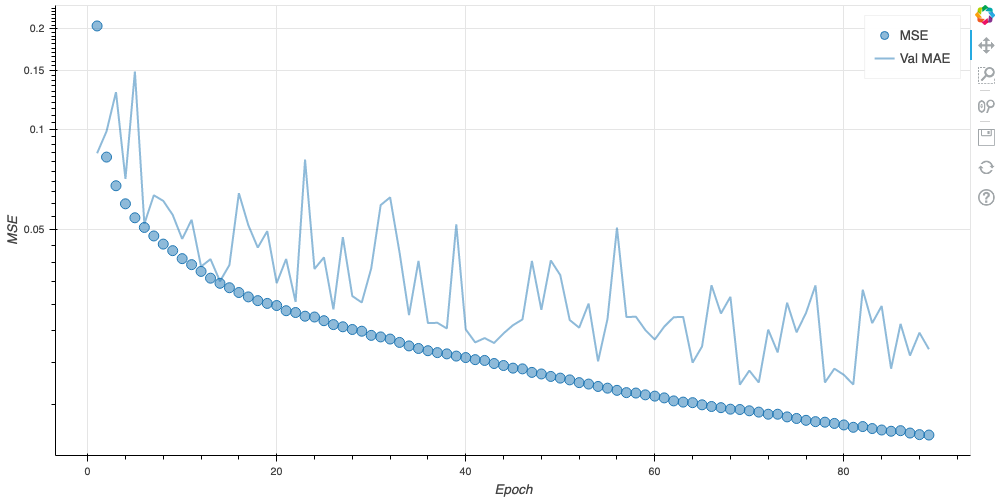

In [9]:
source = pd.DataFrame(history.history)
source['epoch'] = source.index + 1
acc_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='MSE', y_axis_type='log')
acc_plot.circle(x='epoch', y='mean_squared_error', source=source, size=10, fill_alpha=.5, legend_label='MSE')
acc_plot.line(x='epoch', y='val_mean_squared_error', source=source, line_width=2, legend_label='Val MAE', alpha=0.5)
# show(acc_plot)
get_screenshot_as_png(acc_plot, driver=None)

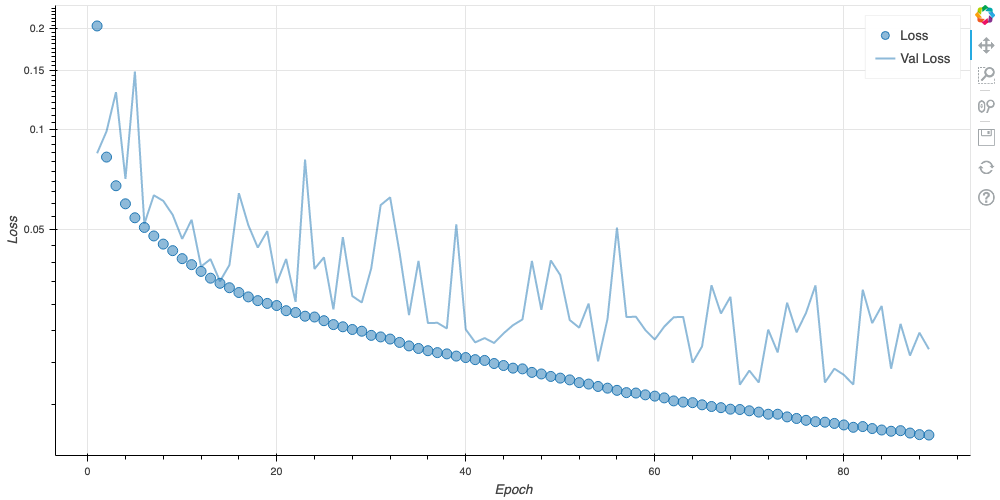

In [10]:
loss_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='Loss', y_axis_type='log')
loss_plot.circle(x='epoch', y='loss', source=source, size=10, fill_alpha=.5, legend_label='Loss')
loss_plot.line(x='epoch', y='val_loss', source=source, line_width=2, legend_label='Val Loss', alpha=0.5)
# show(loss_plot)
get_screenshot_as_png(loss_plot, driver=None)

Previously achieved with NOAA weather data:  
  
Total prediction error: 113288.0  
Total ISOLF prediction error: 63146.0  
Percentage of time the model outperformed the NYISO model: 31.76 (175/551)  
  
  
Hourly results from before:  
  
Total prediction error: 2139681.0
Total ISOLF prediction error: 2174812.0
Percentage of time the model outperformed the NYISO model: 46.51 (6142/13205)

In [16]:
model.load_weights(MODEL_LOCATION)
predictions = model.predict(test.copy().drop(columns=['target']))
isolf = utils.isolf_hourly(lookahead=1)
results = test.copy()
results['prediction'] = predictions
results = results.join(isolf, how='inner')
results['target'] *= std.target
results['target'] += mean.target
results['prediction'] *= std.target
results['prediction'] += mean.target
results['date'] = results.index
results = results.astype({'prediction': 'float'})

results, pred_plot = model_scoring.eval(results)

Total prediction error: 1578053.0
Total ISOLF prediction error: 2174812.0
Percentage of time the model outperformed the NYISO model: 57.33 (7571/13205)


In [12]:
# model.save('checkpoints/jfk_model.h5')

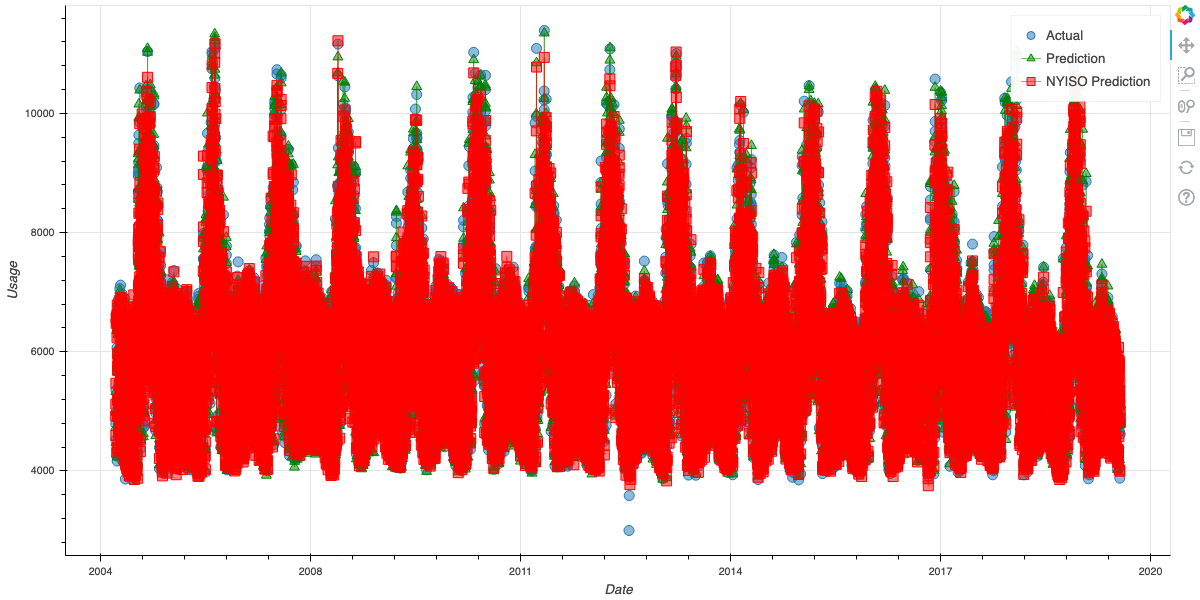

In [13]:
# show(pred_plot)
get_screenshot_as_png(pred_plot, driver=None)

In [14]:
results

,target,temp,dwpt,heat_idx,rh,pressure,vis,wc,wdir,wspd,...,month_8,month_9,month_10,month_11,month_12,prediction,nyiso_prediction,date,prediction_error,nyiso_prediction_error
2006-07-05 11:00:00,8653.464,0.759741,1.250753,0.727533,1.337012,-0.304469,-2.987748,0.764446,-1.778261,-1.012255,...,0,0,0,0,0,7557.901367,8473,2006-07-05 11:00:00,-1095.562633,-180.464
2011-08-01 22:00:00,8777.583,1.040337,1.197771,1.001671,0.511109,-0.851052,0.360180,0.998763,-1.121571,-0.832949,...,1,0,0,0,0,7718.600586,8526,2011-08-01 22:00:00,-1058.982414,-251.583
2008-07-03 09:00:00,8392.483,1.096456,1.038826,1.056499,0.015567,-0.178335,0.360180,1.045627,0.285620,0.780809,...,0,0,0,0,0,7339.213867,7886,2008-07-03 09:00:00,-1053.269133,-506.483
2009-08-21 20:00:00,8890.233,1.096456,1.568643,1.056499,1.392072,-0.430604,0.360180,1.045627,0.097995,-0.115723,...,1,0,0,0,0,7941.376953,8886,2009-08-21 20:00:00,-948.856047,-4.233
2007-10-07 21:00:00,6592.300,0.647502,1.038826,0.617878,1.006651,0.242113,0.360180,0.670719,-0.558695,-0.474336,...,0,0,1,0,0,5710.355469,7303,2007-10-07 21:00:00,-881.944531,710.700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-02 08:00:00,4401.958,-0.418763,-0.338699,-0.423846,0.015567,-1.607859,0.360180,-0.500869,0.660871,0.422196,...,0,0,0,1,0,5489.923340,5650,2012-11-02 08:00:00,1087.965340,1248.042
2007-09-03 16:00:00,7100.550,1.657648,0.879881,1.604774,-1.195758,-0.178335,0.360180,1.514262,0.473246,0.960116,...,0,1,0,0,0,8196.928711,7250,2007-09-03 16:00:00,1096.378711,149.450
2012-11-01 06:00:00,3585.933,-0.811598,-0.338699,-0.807638,0.896530,-1.860128,0.360180,-0.828913,0.473246,-0.115723,...,0,0,0,1,0,4709.041992,4846,2012-11-01 06:00:00,1123.108992,1260.067
2012-07-04 15:00:00,8671.167,1.994364,1.303734,2.098222,-0.975517,-1.103321,0.360180,1.795443,0.848497,-0.295030,...,0,0,0,0,0,10006.393555,8933,2012-07-04 15:00:00,1335.226555,261.833
